<a href="https://colab.research.google.com/github/cmmm976/LyricsExplorer/blob/main/Week_4_Data_Engineering_bootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Engineering 

This bootcamp will be all about wrangling, merging, casting and imputing our data to make it usable for analysis. We will work with time series and complex built up datasets. To prepare you for real world data we will use the Smart meter in London dataset from kaggle: https://www.kaggle.com/jeanmidev/smart-meters-in-london 

In [ ]:
# Import the needed libraries 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import datetime
import os
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
#import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Download the dataset
# 13AuIcqWL5ix6Dw8uQYaykKbdA1ZdGdoL
# 17EFQWPxoekQl2L52sNxV_qfxPwGXOs4f
# 1c5OtEOgMYhkWm7BDDk080tb0DmMBqexL
# 1TSa-KVY0LjyglcGfK0dJDf-x-q1AFxW9

# If the link isn't working copy one of the other links above and try again

!gdown --id 13AuIcqWL5ix6Dw8uQYaykKbdA1ZdGdoL

Downloading...
From: https://drive.google.com/uc?id=13AuIcqWL5ix6Dw8uQYaykKbdA1ZdGdoL
To: /content/Smart_meters_London.zip
100% 103M/103M [00:01<00:00, 75.4MB/s]


In [ ]:
# Unzip the files

from zipfile import ZipFile
file_name="/content/Smart_meters_London.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
acorn = pd.read_csv('/content/Smart_meters_London/acorn_details.csv', encoding= 'unicode_escape')
acorn

,MAIN CATEGORIES,CATEGORIES,REFERENCE,ACORN-A,ACORN-B,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-I,ACORN-J,ACORN-K,ACORN-L,ACORN-M,ACORN-N,ACORN-O,ACORN-P,ACORN-Q
0,POPULATION,Age,Age 0-4,77.0,83.0,72.0,100.0,120.0,77.0,97.0,97.0,63.0,119.0,67.0,114.0,113.0,89.0,123.0,138.0,133.0
1,POPULATION,Age,Age 5-17,117.0,109.0,87.0,69.0,94.0,95.0,102.0,106.0,67.0,95.0,64.0,108.0,116.0,86.0,89.0,136.0,106.0
2,POPULATION,Age,Age 18-24,64.0,73.0,67.0,107.0,100.0,71.0,83.0,89.0,62.0,104.0,459.0,97.0,96.0,86.0,117.0,109.0,110.0
3,POPULATION,Age,Age 25-34,52.0,63.0,62.0,197.0,151.0,66.0,90.0,88.0,63.0,132.0,145.0,109.0,96.0,90.0,140.0,120.0,120.0
4,POPULATION,Age,Age 35-49,102.0,105.0,91.0,124.0,118.0,93.0,102.0,103.0,76.0,111.0,67.0,99.0,98.0,90.0,102.0,103.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,LEISURE TIME,Holiday Destination/Type,Asia,171.0,137.0,94.0,220.0,196.0,69.0,122.0,95.0,72.0,97.0,124.0,73.0,57.0,49.0,96.0,113.0,63.0
822,LEISURE TIME,Holiday Destination/Type,Activity / Outdoor Sports,298.0,278.0,138.0,119.0,93.0,96.0,113.0,96.0,84.0,96.0,56.0,48.0,48.0,46.0,23.0,23.0,23.0
823,LEISURE TIME,Holiday Destination/Type,Cruise,272.0,295.0,272.0,44.0,44.0,70.0,70.0,70.0,70.0,70.0,28.0,28.0,28.0,28.0,49.0,49.0,49.0
824,LEISURE TIME,Holiday Destination/Type,Package,196.0,186.0,166.0,49.0,49.0,101.0,101.0,121.0,106.0,101.0,48.0,75.0,75.0,75.0,54.0,54.0,54.0


# Part 1

### Exersice 1

A) Have a look at [the acorn userguide](https://www.caci.co.uk/sites/default/files/resources/Acorn%20User%20Guide%202020.pdf) to get some insight on what this data means.

B) Look up the value of the category "Playing Golf" for Acorn-A. What does this value mean?

C) Rename the collumns to give each "ACORN" the name that's stated in the user guide. (I've been so kind to provide you with the dictionaire beforehand :)

D) Transpose the dataset so that the categories become the collumn names, the refernces become the sub-collumn names, and the household types are the rows. (Tip: This is called Multi Indexing, you can look it up ;) It should look something like this: 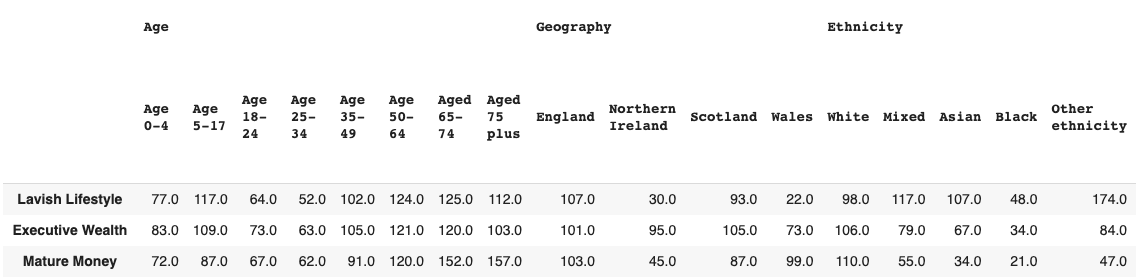


In [ ]:
acorn = acorn.rename(columns={'ACORN-A':'Lavish Lifestyle','ACORN-B':'Executive Wealth','ACORN-C':'Mature Money',
                      'ACORN-D':'City Sophisticates','ACORN-E':'Career Climber','ACORN-F':'Countryside Communities',
                      'ACORN-G':'Successful Suburbs','ACORN-H':'Steady Neaighbourhoods','ACORN-I':'Comfortable Seniors',
                      'ACORN-J':'Starting Out','ACORN-K':'Student Life','ACORN-L':'Modest Means',
                      'ACORN-M':'Striving Families','ACORN-N':'Poorer Pensioners','ACORN-O':'Young Hardship',
                      'ACORN-P':'Struggling Estates','ACORN-Q':'Difficult Circumstances'},errors="raise")


In [ ]:
arrays = [  acorn['CATEGORIES'].values ,
            acorn['REFERENCE'].values  , 
        ]

columns = pd.MultiIndex.from_arrays(arrays)


In [ ]:
new_acorn = acorn.T
new_acorn.columns = columns
new_acorn.drop({'MAIN CATEGORIES','CATEGORIES','REFERENCE'},inplace=True)

In [ ]:
new_acorn

Age                     ... Holiday Destination/Type                      
                        Age 0-4 Age 5-17 Age 18-24  ...                   Cruise Package Self-catering
Lavish Lifestyle             77      117        64  ...                      272     196           308
Executive Wealth             83      109        73  ...                      295     186           181
Mature Money                 72       87        67  ...                      272     166           181
City Sophisticates          100       69       107  ...                       44      49            55
Career Climber              120       94       100  ...                       44      49            55
Countryside Communities      77       95        71  ...                       70     101           127
Successful Suburbs           97      102        83  ...                       70     101           147
Steady Neaighbourhoods       97      106        89  ...                       70     121           124
Comfortable Seniors          63       67        62  ...                       70     106           113
Starting Out                119       95       104  ...                       70     101           166
Student Life                 67       64       459  ...                       28      48            44
Modest Means                114      108        97  ...                       28      75            44
Striving Families           113      116        96  ...                       28      75            44
Poorer Pensioners            89       86        86  ...                       28      75            33
Young Hardship              123       89       117  ...                       49      54            32
Struggling Estates          138      136       109  ...                       49      54            35
Difficult Circumstances     133      106       110  ...                       49      54            35

[17 rows x 826 columns]

### Exercise 2

A) look up the unique values for categories.

B) Create a subset of the category 'Car Ownership'.

C) What household type is most likely to have 3 cars or more?

D) What household type is least likely to have an Iphone?

In [ ]:
from tqdm import tqdm

In [ ]:
unique_values = {'Age':[], 'Geography':[], 'Ethnicity':[], 'Country of Birth':[], 'Religion':[],
       'House Type':[], 'House Tenure':[], 'House Size':[], 'House Value':[],
       'Moving House':[], 'Structure':[], 'Children in household':[],
       'Household Size':[], 'Economic Activity':[],
       'NS Socio-Economic Classifications':[], 'Social Grade':[], 'Occupation':[],
       'Highest Level of Qualifications (Adults)':[],
       'England: Pupils at the end of KS1':[],
       'England: Pupils at the end of KS2':[],
       'England: Pupils at the end of KS4':[],
       'Scotland: Pupils in the S4 cohort':[],
       'Scotland: Pupils in the S5 cohort':[], 'Behaviours & Lifestyle':[],
       'Travel To Work':[], 'Public Transport Accessibility Level':[],
       'Car Ownership':[], 'Main Car Class':[], 'Channels Received':[],
       'Future Responses':[], 'Household Annual Income':[],
       'Financial Attitudes':[], 'Financial Situation':[], 'Benefits':[],
       'Credit Cards':[], 'Savings and Investments':[], 'Loans':[],
       'Insurance and Pensions':[],
       'Financial Channel: Arrange Current Account':[],
       'Financial Channel: Arrange commoditised financial product':[],
       'Financial Channel: Arrange considered financial product':[],
       'Financial Channel: Manage Current Account':[],
       'Financial Channel: Manage Savings Account':[],
       'Expenditure per person per week':[], 'Internet Access: Frequency':[],
       'Internet Access: Usage in Last Week':[], 'Digital Attitudes':[],
       'Technology at Home':[], 'TV on Demand':[], 'Mobile phone':[],
       'Smartphone Brand':[], 'Tablet Devices':[],
       'Social Media Activity (at least weekly)':[],
       'Social Media Brands (used at least weekly)':[],
       'Number of apps on mobile phone (free or paid)':[],
       'Types of internet usage : Laptop or PC':[],
       'Types of internet usage : Mobile Phone':[],
       'Types of internet usage : Tablet / iPad':[],
       'Regularly research on the internet':[], 'Purchased on the internet':[],
       'Sites regularly visited':[], 'Preferred Supermarket':[],
       'Food Shopping':[], 'Clothing & Footwear Stores':[],
       'Furniture & Fittings Stores':[], 'Electrical Stores':[],
       'High Street Retailers':[], 'Attitudes':[], 'Preferred Channel':[],
       'Environmental Groups':[], 'Action':[], 'Attitude':[],
       'Crime Survey for England':[], 'Daily Newspapers':[], 'Magazines Read':[],
       'Charities':[], 'Books Read':[], 'Interests & Hobbies':[],
       'Visit Pubs for a Drink - Day':[], 'Visit Pubs for a Drink - Evening':[],
       'Visit Pubs for a Meal - Day':[], 'Visit Pubs for a Meal - Evening':[],
       'Restaurants - Most Often':[], 'Holiday Destination/Type':[]}

In [ ]:
for category in tqdm(acorn['CATEGORIES'].unique()):
  for sub_category in acorn['REFERENCE'].unique() :
    try:
      for value in new_acorn[category][sub_category].values:
        if value not in unique_values[category]:
          unique_values[category].append(value)
    except KeyError:
      continue
print(unique_values)

100%|██████████| 84/84 [00:42<00:00,  1.99it/s]

{'Age': [77.0, 83.0, 72.0, 100.0, 120.0, 97.0, 63.0, 119.0, 67.0, 114.0, 113.0, 89.0, 123.0, 138.0, 133.0, 117.0, 109.0, 87.0, 69.0, 94.0, 95.0, 102.0, 106.0, 64.0, 108.0, 116.0, 86.0, 136.0, 73.0, 107.0, 71.0, 62.0, 104.0, 459.0, 96.0, 110.0, 52.0, 197.0, 151.0, 66.0, 90.0, 88.0, 132.0, 145.0, 140.0, 105.0, 91.0, 124.0, 118.0, 93.0, 103.0, 76.0, 111.0, 99.0, 98.0, 121.0, 82.0, 126.0, 112.0, 41.0, 78.0, 125.0, 152.0, 55.0, 61.0, 144.0, 182.0, 29.0, 59.0, 157.0, 49.0, 57.0, 220.0, 32.0, 56.0], 'Geography': [107.0, 101.0, 103.0, 114.0, 106.0, 75.0, 102.0, 95.0, 93.0, 97.0, 89.0, 110.0, 30.0, 45.0, 2.0, 49.0, 462.0, 53.0, 104.0, 91.0, 56.0, 87.0, 131.0, 67.0, 43.0, 105.0, 47.0, 144.0, 54.0, 46.0, 167.0, 121.0, 194.0, 139.0, 31.0, 183.0, 22.0, 73.0, 99.0, 10.0, 249.0, 77.0, 84.0, 113.0, 98.0, 211.0, 150.0, 88.0], 'Ethnicity': [98.0, 106.0, 110.0, 83.0, 93.0, 114.0, 94.0, 102.0, 113.0, 103.0, 81.0, 92.0, 111.0, 100.0, 80.0, 117.0, 79.0, 55.0, 248.0, 149.0, 27.0, 84.0, 90.0, 38.0, 116.0, 175

In [ ]:
acorn['CATEGORIES'].unique()

array(['Age', 'Geography', 'Ethnicity', 'Country of Birth', 'Religion',
       'House Type', 'House Tenure', 'House Size', 'House Value',
       'Moving House', 'Structure', 'Children in household',
       'Household Size', 'Economic Activity',
       'NS Socio-Economic Classifications', 'Social Grade', 'Occupation',
       'Highest Level of Qualifications (Adults)',
       'England: Pupils at the end of KS1',
       'England: Pupils at the end of KS2',
       'England: Pupils at the end of KS4',
       'Scotland: Pupils in the S4 cohort',
       'Scotland: Pupils in the S5 cohort', 'Behaviours & Lifestyle',
       'Travel To Work', 'Public Transport Accessibility Level',
       'Car Ownership', 'Main Car Class', 'Channels Received',
       'Future Responses', 'Household Annual Income',
       'Financial Attitudes', 'Financial Situation', 'Benefits',
       'Credit Cards', 'Savings and Investments', 'Loans',
       'Insurance and Pensions',
       'Financial Channel: Arrange Current Ac

In [ ]:
new_acorn['Car Ownership']['Number of Cars 0']

Lavish Lifestyle            23
Executive Wealth            26
Mature Money                24
City Sophisticates         208
Career Climber             118
Countryside Communities     48
Successful Suburbs          31
Steady Neaighbourhoods      46
Comfortable Seniors         47
Starting Out                48
Student Life               235
Modest Means                64
Striving Families          105
Poorer Pensioners          207
Young Hardship             225
Struggling Estates         214
Difficult Circumstances    315
Name: Number of Cars 0, dtype: object

In [ ]:
new_acorn['Car Ownership']['Number of Cars 3+']

Lavish Lifestyle           126
Executive Wealth           170
Mature Money               133
City Sophisticates          92
Career Climber              96
Countryside Communities    134
Successful Suburbs         102
Steady Neaighbourhoods      74
Comfortable Seniors         98
Starting Out               100
Student Life                96
Modest Means               113
Striving Families           96
Poorer Pensioners           56
Young Hardship              36
Struggling Estates          35
Difficult Circumstances     34
Name: Number of Cars 3+, dtype: int64

Executive Wealth household is the most susceptible to have 3 or more cars.

In [ ]:
new_acorn['Smartphone Brand']['iPhone']

Lavish Lifestyle           145
Executive Wealth           128
Mature Money                98
City Sophisticates         167
Career Climber             151
Countryside Communities     82
Successful Suburbs         110
Steady Neaighbourhoods     108
Comfortable Seniors         62
Starting Out               119
Student Life               140
Modest Means                92
Striving Families           90
Poorer Pensioners           55
Young Hardship              91
Struggling Estates          99
Difficult Circumstances     75
Name: iPhone, dtype: object

City Sophisticates household is the most susceptible to have an iPhone.

### Exercise 3

A) What household has the lowest score most frequently?

B) What household has the highest score most frequently?

# Part 2

### Exercise 1

From here we will try to predict the overall energy consumption in London for a certain time. Have a look at the Smart_meters_London/daily_dataset/daily_dataset folder.

A) Open block_0.csv and take a look at the columns

B) Find out what the column LCLid means

Now we will try to combine all block.csv files and create 1 dataframe that contains all information.

C) Open a new csv file to write a new dataframe to. Name it "blocks_combined"

D) Append the dataframe from block_0 to blocks_combined

E) Create a loop to append all "block_x.csv" files to your new blocks_combined file so that you have all the information in one dataframe

### Exercise 2

A) See if blocks_combined has missing values.

B) Use the Iterative Imputer from SKlearn to impute the missing values in columns 'energy_std'

C) Check the mean and std of blocks combined with pandas profiling, and compare it with the mean and std of the column 'energy_std' with imputed values.

D) Use sample_posterior = True to do multiple imputation instead of single imputation and generate new values. 

E) Do the same as for 2C and check if there is any difference in mean and std.

F) Replace the NaN values with the values you imputed at 2D

In [ ]:
!pip install pandas_profiling==2.9.0 -U -q

In [ ]:
from pandas_profiling import ProfileReport
ProfileReport(blocks_combined, minimal=True)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


### Exercise 3

Now that we have our data set we can start exploring it. If you did exercise 1 right you found out that LCLid corresponds with the household ID. Now, before we start running models on our data it is important to know what our training data looks like.

A) Use value_counts() to make a count plot of the column 'day'

B) Transform the dtype of column 'day' from object to datetime

C) Make the same plot from 2A again

D) What does this plot tell you?

### Exercise 4

In order to make accurate predictions for energy consumption it is important that the data is consistant. Therefore we will make a new dataframe called "energy_per_household" that takes into account how many houses were using a smart meter at a certain time.

A) Create a dataframe with a variable called 'nHouses' that holds the number of houses measured for each date.

B) Create a dataframe with a variable called 'energy_sum' that holds the total sum of all energy used on a date.

C) Merge these 2 new dataframes together and add a variable called 'avg_energy' that holds the average energy consumption per household.

### Exercise 5

A) Add a column that states if the date is a weekend day (use pandas.datetime)

B) Check the difference in avg_energy between week days and weekend days

### Exercise 6

Now that we have our target variables. We will add weather information to see if we can predict energy consumption. 

A) Open the 'weather_daily_darksky.csv' file and have a look at the variables

B) Add a new variable called 'day' that has dtype datetime. Use 'time' to create this variable

C) Select all the numeric variables and drop all missing values.

D) Merge your new weather dataframe with the energy_per_household dataframe on 'day'

E) Run the plot and have a look at the relationship between temperature and engery consumption

In [ ]:
#code for the plot from 6E

fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

### Exercise 7 Advanced

A) Make a correlation matrix of the weather variables and avg_energy. 

You will see that there is a lot of multicollinearity in this dataset. That is because apparent temperatures are a function of other variables like humidity, tempratureMax, and windspeed.

B) Delete all columns with "apparent' in the name

C) Run a feature selection algorithm of your choice to select the optimal amount of features.

D) Make a new dataframe that only consists of variables that were selected during feature selection

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor


### Exercise 8 - Advanced. Training the model 

Use the dataframe your created at exercise 7

A) Study the code below to get insight on how forcasting works.


In [ ]:
new_weather_energy.set_index(['day'],inplace=True)
new_weather_energy

In [ ]:
model_data = new_weather_energy
# train = model_data.iloc[0:round(len(model_data)*0.90)]
# test = model_data.iloc[len(train)-1:]
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

In [ ]:
train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))


In [ ]:
test.head(1)

In [ ]:
train = train.dropna()
test = test.dropna()

In [ ]:
train.info()

In [ ]:
endog = train['avg_energy']
exog = sm.add_constant(train[['temperatureMax','dewPoint','cloudCover','windSpeed','visibility','humidity','uvIndex','temperatureMin','weekend']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,1,1),seasonal_order=(1,1, 0, 12),trend='c')
model_fit = mod.fit()
model_fit.summary()

In [ ]:
train['avg_energy'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

In [ ]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['temperatureMax','dewPoint','cloudCover','windSpeed','visibility','humidity','uvIndex','temperatureMin','weekend']]))
test['predicted'] = predict.values
test.tail(5)

In [ ]:
test['residual'] = abs(test['avg_energy']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['avg_energy']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

In [ ]:
test['avg_energy'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()